In [1]:
import synthtiger
# import the necessary packages
from imutils import contours
import numpy as np
import imutils
import cv2
from skimage.segmentation import clear_border
from matplotlib import pyplot as plt

from pdf2image import convert_from_path
import PIL
from PIL import ImageDraw,ImageFont,Image

import fitz

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
def file_to_images(file, gray=False):
    if file[-3:].lower() == 'pdf':
        imgs = []
        
        zoom = 3    # zoom factor
        mat = fitz.Matrix(zoom, zoom)
        
        with fitz.open(file) as pdf:
            for pno in range(pdf.page_count):
                page = pdf.load_page(pno)
                pix = page.get_pixmap(matrix=mat)
                # if width or height > 2000 pixels, don't enlarge the image
                #if pix.width > 2000 or pix.height > 2000:
                #    pix = page.get_pixmap(matrix=fitz.Matrix(1, 1)
                
                mode = "RGBA" if pix.alpha else "RGB"                        
                img = Image.frombytes(mode, [pix.width, pix.height], pix.samples)                        
                
                if gray:
                    img = img.convert('L')
                else:
                    img = img.convert('RGB')
                    
                imgs.append(img)
    else:
        if gray:
            img = Image.open(file).convert('L')
        else:
            img = Image.open(file).convert('RGB')
            
        imgs=[img]

    return imgs

# Lib

In [3]:
def create_yolo_annotations(mask_comp, labels_comp):
    comp_w, comp_h = mask_comp.shape[1], mask_comp.shape[0]
    
    obj_ids = np.unique(mask_comp).astype(np.uint8)[1:]
    masks = mask_comp == obj_ids[:, None, None]

    annotations_yolo = []
    for i in range(len(labels_comp)):
        pos = np.where(masks[i])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])

        xc = (xmin + xmax) / 2
        yc = (ymin + ymax) / 2
        w = xmax - xmin
        h = ymax - ymin

        annotations_yolo.append([labels_comp[i] - 1,
                                 round(xc/comp_w, 5),
                                 round(yc/comp_h, 5),
                                 round(w/comp_w, 5),
                                 round(h/comp_h, 5)])

    return annotations_yolo

In [4]:
def generate_dataset(imgs_number, folder, split='train'):
    time_start = time.time()
    for j in tqdm(range(imgs_number)):
        img_comp_bg = create_bg_with_noise(files_bg_imgs,
                                           files_bg_noise_imgs,
                                           files_bg_noise_masks,
                                           max_objs_to_add=60)
        
        img_comp, mask_comp, labels_comp, _ = create_composition(img_comp_bg,
                                                                 max_objs=15,
                                                                 overlap_degree=0.2,
                                                                 max_attempts_per_obj=10)

        img_comp = cv2.cvtColor(img_comp, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(folder, split, 'images/{}.jpg').format(j), img_comp)

        annotations_yolo = create_yolo_annotations(mask_comp, labels_comp)
        for i in range(len(annotations_yolo)):
            with open(os.path.join(folder, split, 'labels/{}.txt').format(j), "a") as f:
                f.write(' '.join(str(el) for el in annotations_yolo[i]) + '\n')
                
    time_end = time.time()
    time_total = round(time_end - time_start)
    time_per_img = round((time_end - time_start) / imgs_number, 1)
    
    print("Generation of {} synthetic images is completed. It took {} seconds, or {} seconds per image".format(imgs_number, time_total, time_per_img))
    print("Images are stored in '{}'".format(os.path.join(folder, split, 'images')))
    print("Annotations are stored in '{}'".format(os.path.join(folder, split, 'labels')))

In [5]:
from PIL import ImageDraw,ImageFont

def draw_boxes(image, boxes, color='green', width=2):
    draw = ImageDraw.Draw(image, "RGBA")
    for box in boxes:
        if color=='green':
            fill=(0, 255, 0, 127)
        else:
            fill=(255, 0, 0, 127)
        draw.rectangle(box, outline=(color), width=width,fill=fill)
        
    return image

# def draw_boxes(image, bounds, color='green', width=2):
#     draw = ImageDraw.Draw(image)
#     font = ImageFont.load_default()
#     for bound in bounds:
#         #print(bound)
#         p0, p1, p2, p3 = bound
#         draw.line([*p0, *p1, *p2, *p3, *p0], fill=color, width=width)
#         #draw.text((p0[0]+10,p0[1]-10), bound[1][:5],fill='green',font=font)
#     return image

# Test

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import os
os.environ['PYTHONPATH'] = "/Users/ihor/Documents/Py/Yay/OCR/donut-synthdog"

In [26]:
from template import Remittance
remittance = Remittance('config/config_en.yaml')

(1840, 546)


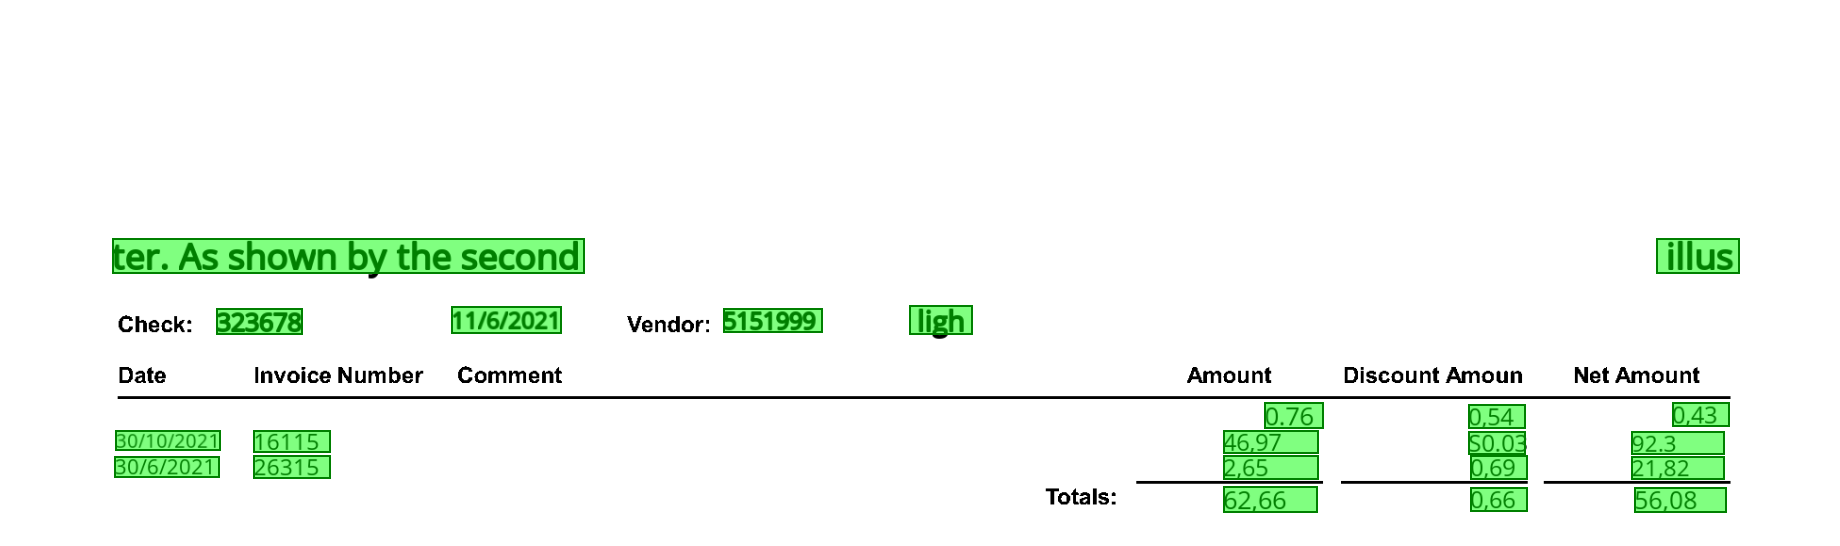

In [33]:
sample = remittance.generate()
#Image.fromarray(sample['image'][..., :3].astype(np.uint8)).resize((200,200))
im= Image.fromarray(sample['image'][..., :3].astype(np.uint8))
print(im.size)
draw_boxes(im,[x['box'] for x in sample['label']])

In [23]:
import json
image = file_to_images('paper/rem1.png')[0]
with open('paper/rem1.json') as json_file:
    boxes = json.load(json_file)

In [53]:
def labelbox_box_to_image_box(bbox,width_scale,heights_scale):
    return [
        bbox['left']*width_scale,
        bbox['top']*heights_scale,
        (bbox['left']+bbox['width'])*width_scale,
        (bbox['top']+bbox['height'])*heights_scale,
        ]

In [54]:
bboxes = [labelbox_box_to_image_box(t['bbox'],1,1) for t in boxes]

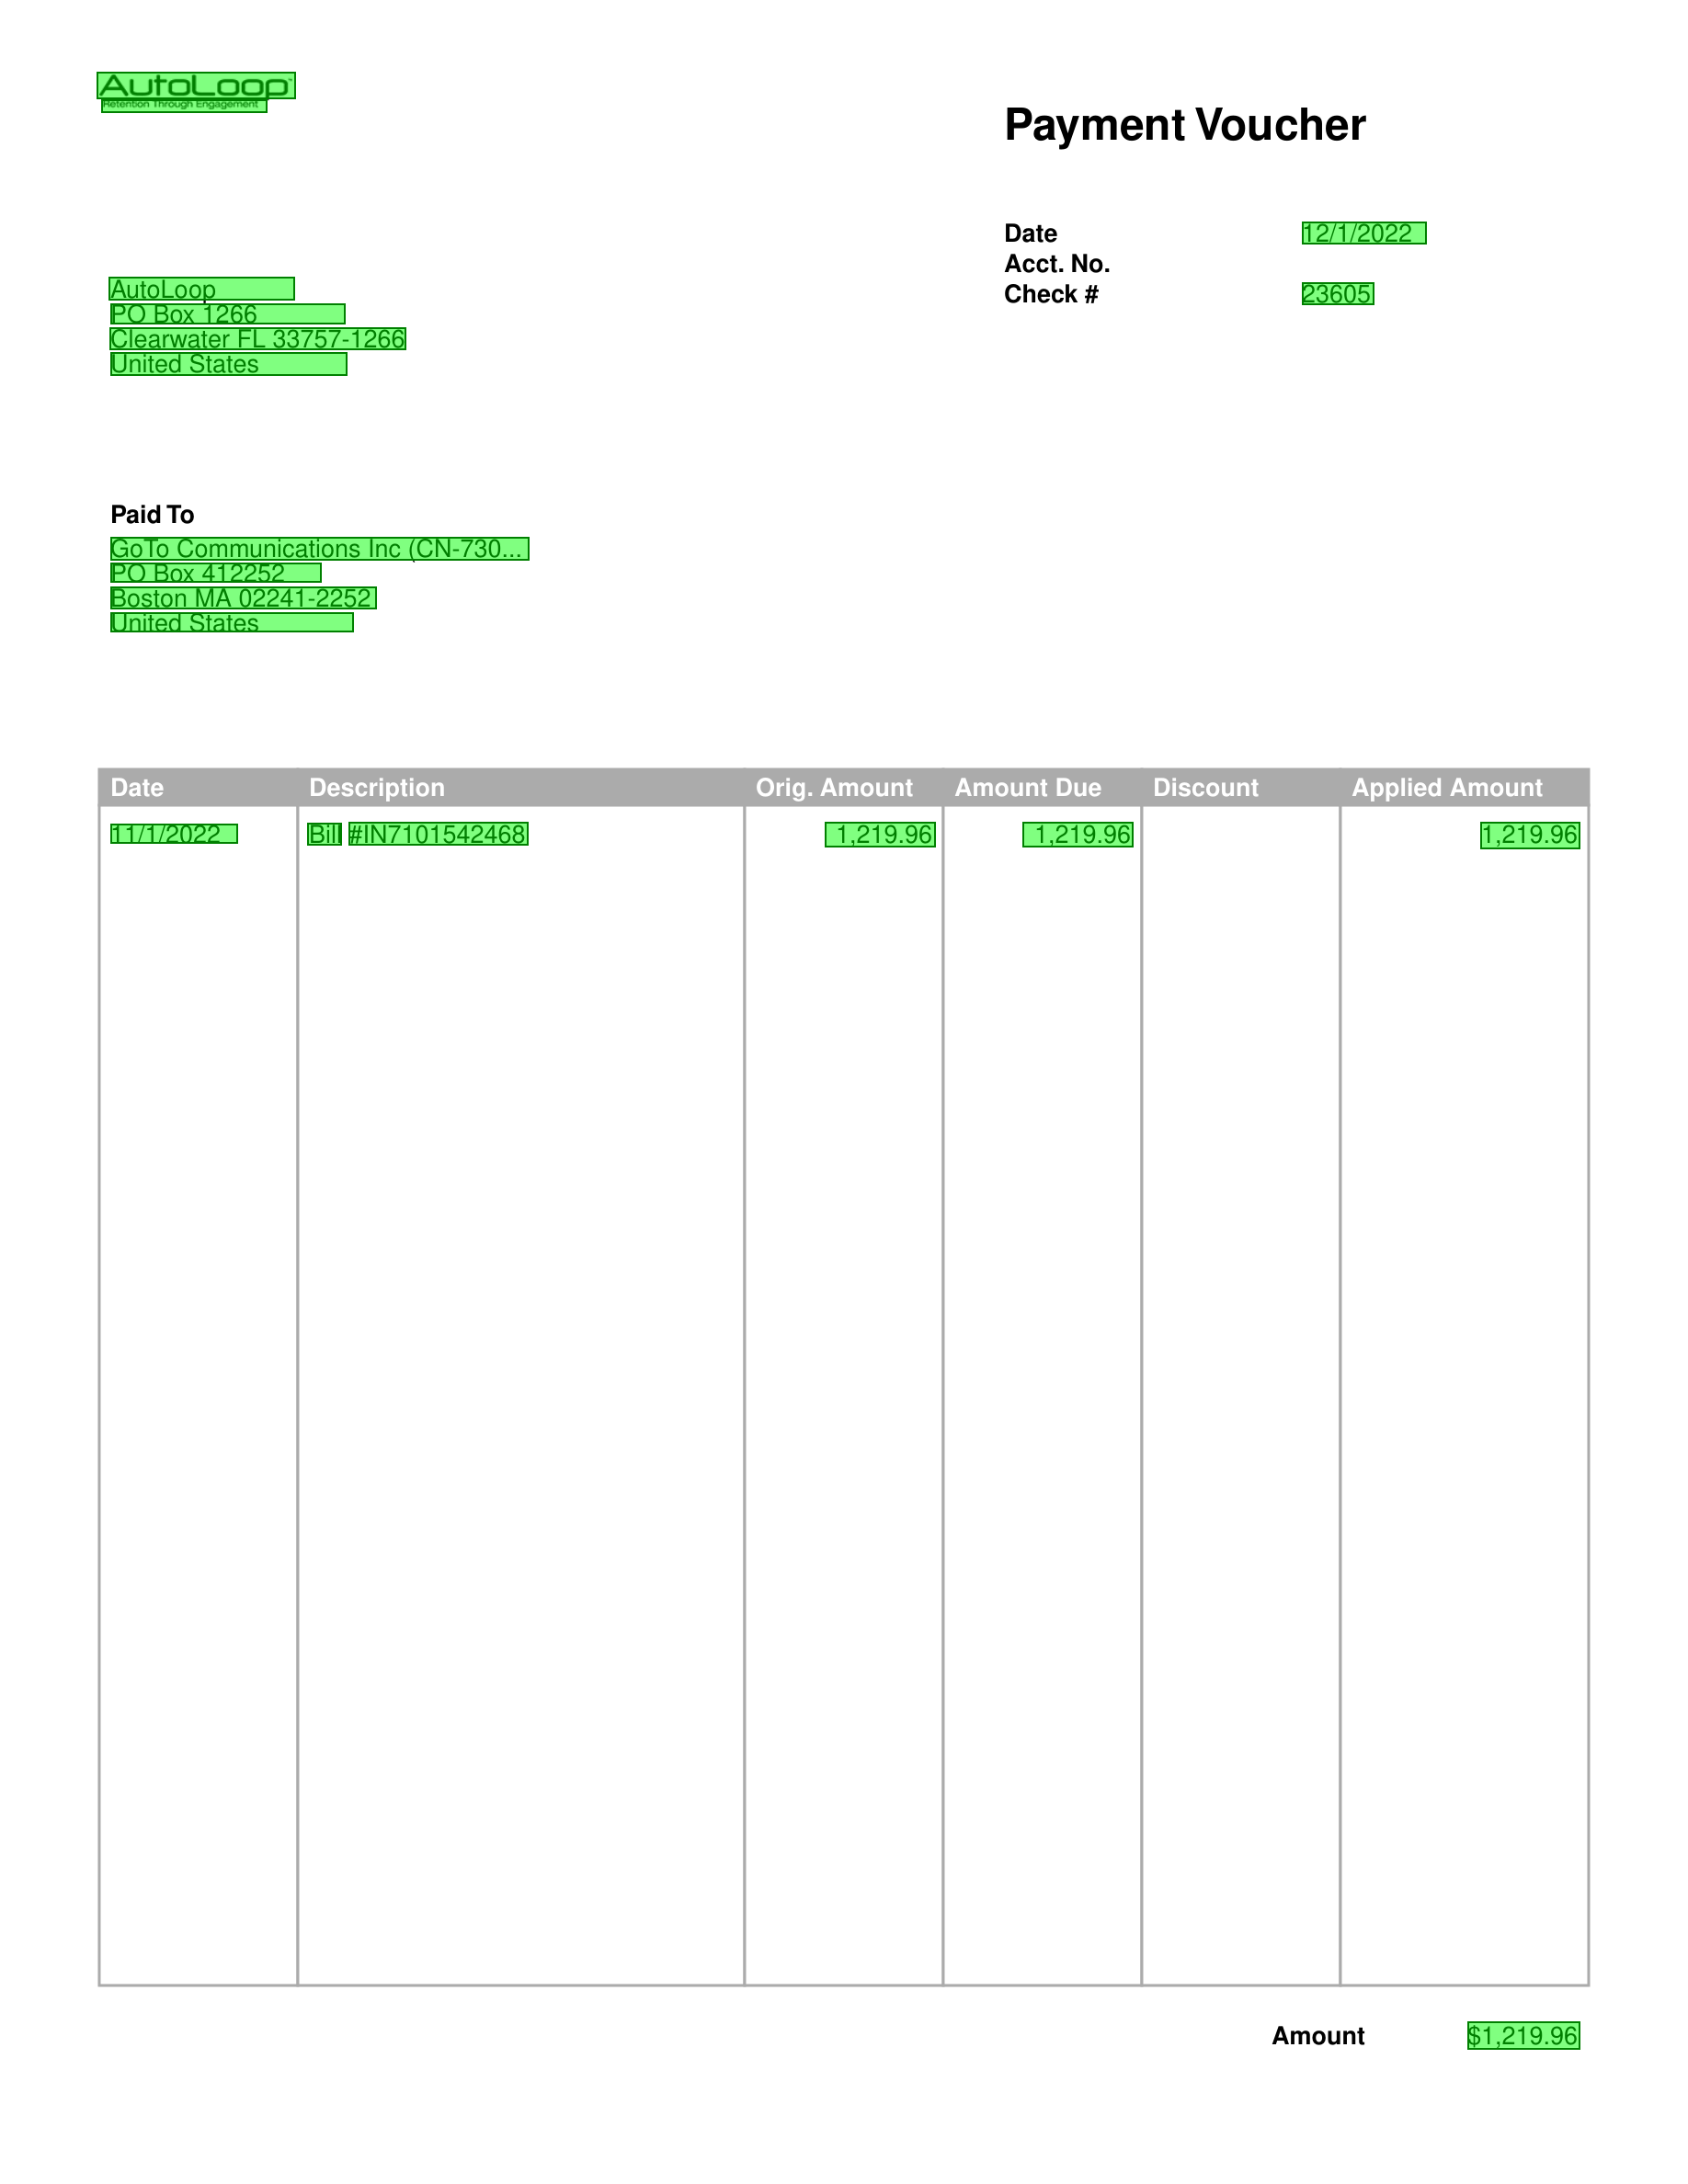

In [55]:
draw_boxes(image.copy(),bboxes)

In [40]:
image.size

(1836, 2376)

In [41]:
bboxes

[[3240, 24192, 6966, 24759],
 [3240, 8910, 10125, 9504],
 [3213, 9612, 11907, 10260],
 [3240, 10341, 10179, 11016],
 [3240, 16524, 9423, 17091],
 [3240, 17226, 11043, 17874],
 [3240, 17982, 10368, 18549],
 [24219, 24138, 27459, 24867],
 [30024, 24138, 33264, 24867],
 [43470, 24138, 46386, 24921],
 [2835, 2106, 8667, 2889],
 [3240, 15768, 15525, 16443],
 [9018, 24165, 10017, 24813],
 [2970, 2916, 7830, 3294],
 [43092, 59373, 46386, 60183],
 [38232, 6507, 41877, 7155],
 [3186, 8127, 8640, 8802],
 [10233, 24138, 15498, 24813],
 [38232, 8289, 40338, 8937]]